 # 重采样层 (Resampling Layers)

 在处理神经算子（Neural Operators）时，我们经常需要改变数据的分辨率。对于某些网络架构（如FNO，傅里叶神经算子），由于傅里叶域具有分辨率不变性，分辨率的调整会被自动处理。


 然而对于其他架构（如U-Net），我们需要在数据流经网络时显式地进行上采样和下采样操作。neuralop库中的`neuralop.layers.resample`函数提供了一种便捷的实现方式。


 本示例将演示如何使用`resample`函数对**高斯随机场（Gaussian Random Field, GRF）** 样本进行上/下采样：

 - 高斯随机场是平滑连续的信号，相比分段常数数据，更适合直观观察插值效果

 - 对于1D/2D输入：resample函数使用PyTorch内置的空间插值器（1D用线性插值，2D用双三次插值），效率更高

 - 对于3D及更高维输入：resample函数切换为基于傅里叶变换的谱插值方法（通过FFT将信号转到频域，调整频率表示后逆变换，实现无混叠的平滑插值）

In [5]:
# 导入核心模块
import torch  # PyTorch核心库，用于张量计算和深度学习
import matplotlib.pyplot as plt  # 绘图库，用于可视化结果
from neuralop.layers.resample import resample  # 导入neuralop的重采样函数


 ## 步骤1：生成输入数据

 首先生成高分辨率的高斯随机场（GRF）—— 它是平滑连续的信号，非常适合可视化重采样的效果。

In [6]:
# 设置计算设备为CPU（示例简化，无需GPU）
device = "cpu"


def generate_grf(shape, alpha=2.5, device="cpu"):
    """
    生成二维高斯随机场（Gaussian Random Field, GRF）
    
    参数说明：
    ----------
    shape : tuple
        输出张量的空间维度形状 (高度, 宽度)
    alpha : float, 可选
        控制随机场平滑度的参数：alpha越大，随机场越平滑（默认2.5）
    device : str, 可选
        生成张量的设备（cpu/cuda，默认cpu）
    
    返回值：
    ----------
    torch.Tensor
        4维张量，形状为 (batch维度, 通道维度, 高度, 宽度)，符合神经网络输入格式
    """
    # 解析空间维度的高和宽
    n, m = shape
    # 生成x/y方向的频率坐标（基于FFT的频率采样）
    # view(-1,1)/view(1,-1)是为了后续广播计算频率的平方和
    freq_x = torch.fft.fftfreq(n, d=1 / n, device=device).view(-1, 1)
    freq_y = torch.fft.fftfreq(m, d=1 / m, device=device).view(1, -1)

    # 计算频率的平方范数（用于功率谱滤波）
    norm_sq = freq_x**2 + freq_y**2
    # 避免0频率处的除以0错误（0频率对应直流分量）
    norm_sq[0, 0] = 1.0  

    # 1. 在频域生成复数值的白噪声（高斯随机噪声）
    noise = torch.randn(n, m, dtype=torch.cfloat, device=device)

    # 2. 对噪声应用幂律滤波器（生成符合高斯随机场的频域分布）
    # alpha控制滤波强度：alpha越大，高频分量被压制得越厉害，最终场越平滑
    filtered_noise = noise * (norm_sq ** (-alpha / 2.0))

    # 3. 逆二维FFT将频域信号转换回空间域，取实部（虚部是数值误差，可忽略）
    field = torch.fft.ifft2(filtered_noise).real

    # 4. 归一化到[0,1]区间（方便可视化，消除数值范围差异）
    field = (field - field.min()) / (field.max() - field.min())

    # 5. 添加batch维度（第0维）和通道维度（第1维），适配神经网络输入格式
    return field.unsqueeze(0).unsqueeze(0)  


# 生成128x128的高分辨率高斯随机场作为"真实数据"
high_res = 128  # 高分辨率尺寸
high_res_data = generate_grf((high_res, high_res), device=device)

# 定义下采样后的低分辨率尺寸（4倍下采样：128/4=32）
low_res = 32


 ## 步骤2：执行重采样操作

 使用`resample`函数模拟U-Net编码器（下采样）和解码器（上采样）的核心操作：

 - resample函数参数：输入张量 + 缩放因子 + 需要重采样的维度列表

 - 缩放因子 < 1：下采样；缩放因子 > 1：上采样

In [7]:
# 计算下采样因子：32/128 = 0.25（从128x128降到32x32）
downsample_factor = low_res / high_res
# 执行下采样：[2,3]表示对第2、3维（高度、宽度）进行重采样
downsampled_data = resample(high_res_data, downsample_factor, [2, 3])

# 计算上采样因子：128/32 = 4（从32x32恢复到128x128）
upsample_factor = high_res / low_res
# 执行上采样：将下采样后的低分辨率数据恢复为原尺寸
upsampled_data = resample(downsampled_data, upsample_factor, [2, 3])


 ## 步骤3：可视化重采样结果

 对比原始高分辨率、下采样、上采样后的数据，直观观察重采样效果

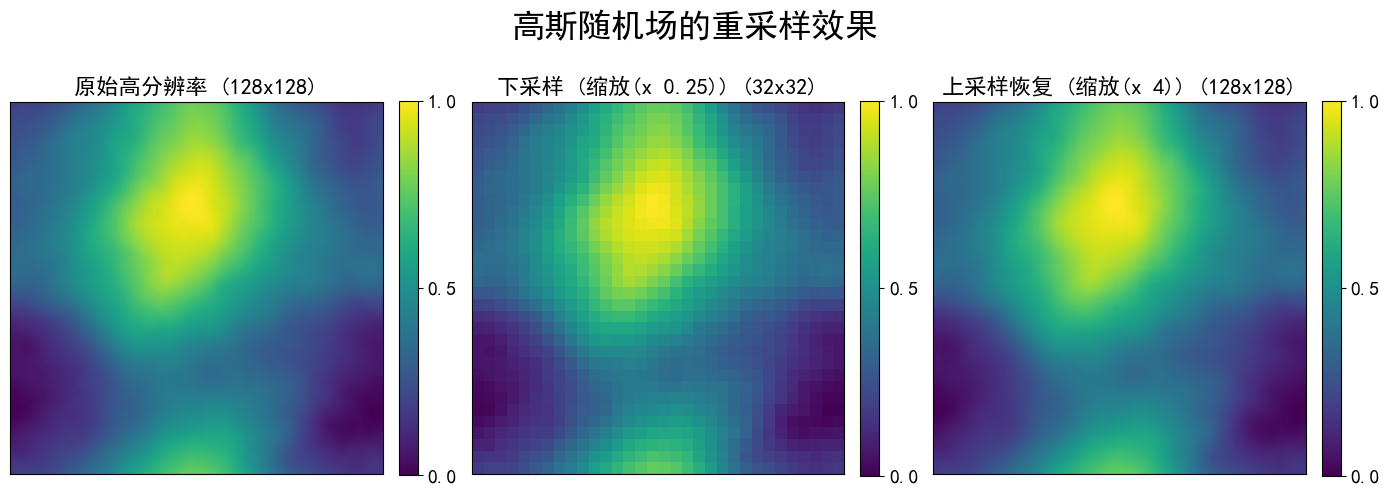

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号


# 创建1行3列的子图，设置画布大小
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
# 调整子图之间的间距（避免重叠）
plt.subplots_adjust(wspace=0.04)
# 设置总标题（字体大小24）
fig.suptitle("高斯随机场的重采样效果", fontsize=24)

# 1. 绘制原始高分辨率数据
# squeeze()去除batch和通道维度（从4维变2维），转numpy用于绘图
im1 = axs[0].imshow(high_res_data.squeeze().cpu().numpy(), cmap="viridis", vmin=0, vmax=1)
axs[0].set_title(f"原始高分辨率 ({high_res}x{high_res})", fontsize=16, fontweight="bold")
# 添加颜色条（刻度0/0.5/1，统一数值范围）
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(labelsize=14)  # 调整颜色条刻度字体大小

# 2. 绘制下采样后的数据
im2 = axs[1].imshow(downsampled_data.squeeze().cpu().numpy(), cmap="viridis", vmin=0, vmax=1)
axs[1].set_title(f"下采样 (缩放(x {downsample_factor})) ({low_res}x{low_res})", fontsize=16, fontweight="bold")
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(labelsize=14)

# 3. 绘制上采样后的数据
im3 = axs[2].imshow(upsampled_data.squeeze().cpu().numpy(), cmap="viridis", vmin=0, vmax=1)
axs[2].set_title(f"上采样恢复 (缩放(x {upsample_factor:.0f})) ({high_res}x{high_res})", fontsize=16, fontweight="bold")
cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04, ticks=[0, 0.5, 1])
cbar3.ax.tick_params(labelsize=14)

# 隐藏所有子图的坐标轴刻度（美化可视化效果）
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# 调整布局（避免标题和子图重叠），显示图像
plt.tight_layout(rect=[0, 0.03, 1, 1.08])
plt.show()


 ## 结果分析

 resample函数能有效调整数据分辨率：

 - 下采样会丢失高频细节（信息损失）

 - 上采样能恢复尺寸，但无法完全还原丢失的高频细节（因此上采样后的图像会略模糊）

 这也是U-Net等架构需要跳跃连接（Skip Connection）补充细节的核心原因。